# Tabulated Prior Example
The main purpose of this code is to demonstrate how one can fix the prior-likelihood to a constant value and use multinest to sample the prior space log-uniformly. Within this script, one can use the ``PosteriorAnalysis.py``script to generate the prior axuiliary data and the prior 95% confidence intervals. 


The following block of code will properly import NEoST and its prerequisites, furthermore it also defines a name for the inference run, this name is what will be prefixed to all of NEoST's output files.

The machinary used within this script and the explanation of them is identical to those found in the Piecewise Polytropic, Speed of Sound, and Tabulated Examples.

In [1]:
import neost
from neost.eos import tabulated
from neost.Prior import Prior
from neost.Star import Star
from neost.Likelihood import Likelihood
from neost import PosteriorAnalysis
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib
from matplotlib import pyplot
from pymultinest.solve import solve
import time
import os
#if not os.path.exists("chains"): 
#   os.mkdir("chains")
import neost.global_imports as global_imports

# Some physical constants
c = global_imports._c
G = global_imports._G
Msun = global_imports._M_s
pi = global_imports._pi
rho_ns = global_imports._rhons

# Define name for run
run_name = "prior-tabulated-"

using c code


Below, we define the AP4 tabulated equation of state model, import the likelihood functions of the synthetic sources, and set the variable paramaeters with their respective prior space intervals.

In [2]:
# We're exploring a tabulated (T) EoS 
eos_name = 'tabulated'

baryondensity, pressure_B, energydensity_B = np.loadtxt('../../examples/ap4_new.dat', unpack=True) #in units of g/cm^3 for all values

pressure_B = pressure_B*c**2 #(in units of g/(cm s^2))

energydensity_B = energydensity_B

# Defining the base EoS model
tabulated_example = tabulated.TabulatedEoS(energydensity_B,pressure_B)
tabulated_example.update({}, max_edsc=True)

# Create the likelihoods for the individual measurements
# Here just a simple 2D gaussian.

muM = 2.0947   #synthetic source with log_10(central energy density) = 15.240180657118929
muR = 10.808
sigM = 0.05*muM # 5% uncertainty in mass 
sigR = 0.05*muR # 5% uncertainty in radius
test = multivariate_normal(mean=[muM, muR], cov=[[sigM, 0.0], [0.0, sigR]])

muM2 = 1.7090   #synthetic source with log_10(central energy density) = 15.07681219601247
muR2 = 11.312
sigM2 = 0.05*muM2 # 5% uncertainty in mass 
sigR2 = 0.05*muR2 # 5% uncertainty in radius
test2 = multivariate_normal(mean=[muM2, muR2], cov=[[sigM2, 0.0], [0.0, sigR2]])

muM3 = 1.0814   #synthetic source with log_10(central energy density) = 14.913443734906012
muR3 = 11.4587
sigM3 = 0.05*muM3 # 5% uncertainty in mass 
sigR3 = 0.05*muR3 # 5% uncertainty in radius
test3 = multivariate_normal(mean=[muM3, muR3], cov=[[sigM3, 0.0], [0.0, sigR3]])

likelihood_functions = [test.pdf,test2.pdf,test3.pdf]
likelihood_params = [['Mass', 'Radius'],['Mass', 'Radius'],['Mass', 'Radius']]

# This is not a GW event so we set chirp mass to None
chirp_mass = [None, None, None]
number_stars = len(chirp_mass)

#Only vary the central densities on the sources because there are no parameters to vary in a tabulated equation of state
variable_params = {}
for i in range(number_stars):
	variable_params.update({'rhoc_' + str(i+1):[14.6, 16]})

Similar to the posterior analysis tutorials, we define the static parameters (which there are none in this example), define and update the variable parameters for each source (one for this case), and define the prior object. Additionally, we define a prior ``loglike`` function, which defines a constant prior log-likelihood value for each sample drawn of each parameter (``pseudo_var``). This is defined in this way such that each sample has an equal prior likelihood of being drawn, thus we have a suffciently uniform and non-informative prior for each parameter in the equation of state.

In [3]:
# Define static parameters, empty dict because all params are variable 
static_params={}

# Define prior
prior = Prior(tabulated_example, variable_params, static_params, chirp_mass)

print("Bounds of prior are")
print(variable_params)
print("number of parameters is %d" %len(variable_params))

# Define likelihood, pseudo_var is required as input because NEoST expects to be able to pass the parameter sample drawn from the prior to be passable to the likelihood
def loglike(pseudo_var):
    return 1.

Bounds of prior are
{'rhoc_1': [14.6, 16], 'rhoc_2': [14.6, 16], 'rhoc_3': [14.6, 16]}
number of parameters is 3


In [4]:
# No prior & likelihood test, there is no likelihood after all
# print("Testing prior and likelihood")
# cube = np.random.rand(50, len(variable_params))
# for i in range(len(cube)):
#     par = prior.inverse_sample(cube[i])
#     print(likelihood.call(par))
# print("Testing done")

Here, we implement multinest to uniformly sample the prior space and for each sample from the prior that it draws it assigns a constant prior log-likelihood value of 1. Note, the greatly increased number of livepoints. This is required because each livepoint terminates after 1 iteration.

In [5]:
# Then we start the sampling, note the greatly increased number of livepoints, this is required because each livepoint terminates after 1 iteration
start = time.time()
result = solve(LogLikelihood=loglike, Prior=prior.inverse_sample, n_live_points=10000, evidence_tolerance=0.1,
               n_dims=len(variable_params), sampling_efficiency=0.8, outputfiles_basename='../../examples/chains/' + run_name, verbose=True)
end = time.time()
print(end - start)

  analysing data from ../../examples/chains/prior-tabulated-.txt
1430.4026911258698


Total number of samples is 10000
|████████████████████████████████████████| 10000/10000 [100%] in 31:39.5 (5.26/s) 


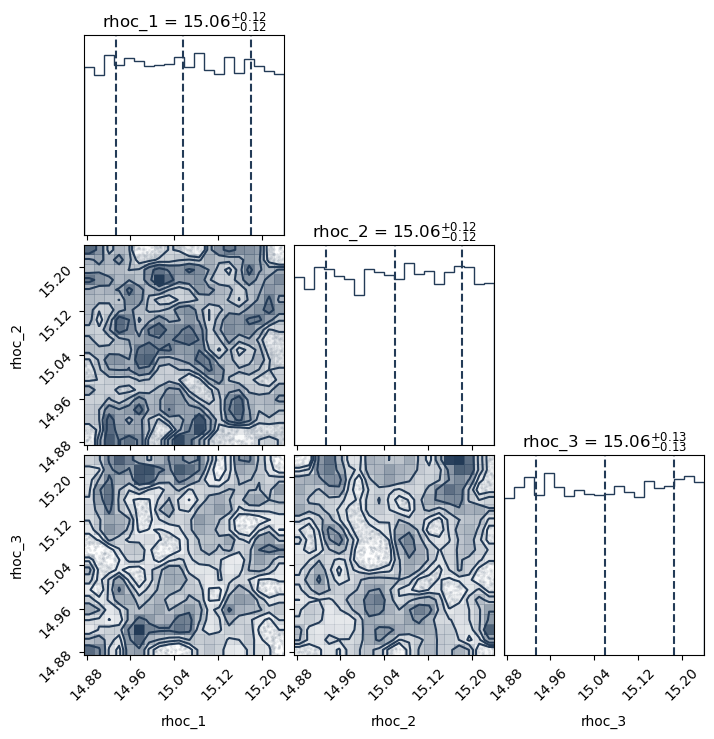

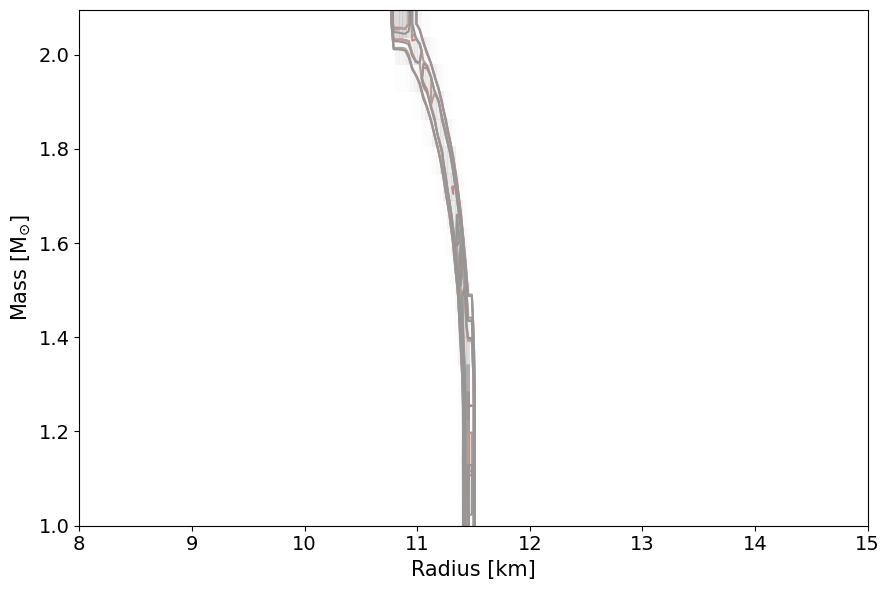

In [6]:
# Compute auxiliary data for posterior analysis
PosteriorAnalysis.compute_auxiliary_data('../../examples/chains/' + run_name, tabulated_example,
                                         variable_params, static_params, chirp_mass)


# Make some analysis plots
PosteriorAnalysis.cornerplot('../../examples/chains/' + run_name, variable_params)
PosteriorAnalysis.mass_radius_posterior_plot('../../examples/chains/' + run_name)

#Will throw an error stating the the underlying equation of state is fixed because there are no parameters to vary
#for a tabulated EoS
#PosteriorAnalysis.mass_radius_prior_predictive_plot('chains/' + run_name,variable_params, label_name='+ Synthetic dataset')
#PosteriorAnalysis.eos_posterior_plot('chains/' + run_name,variable_params)
